### **Download and extract Food 101 Dataset**

In [1]:
import os
import cv2
import random
import numpy as np
%matplotlib inline
import numpy as np
import collections
from shutil import copy
import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
import matplotlib.image as img
import matplotlib.pyplot as plt
from collections import defaultdict
from shutil import copytree, rmtree
from tensorflow.keras import models
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D

In [2]:
# Check if GPU is enabled
print(tf.__version__)
print(tf.test.gpu_device_name())

1.12.0
/device:GPU:0


In [3]:
%cd /kaggle/input/food-101/

/kaggle/input/food-101


In [4]:
# Helper function to download data and extract
def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    print("Downloading the data...")
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print("Dataset downloaded!")
    print("Extracting data..")
    !tar xzvf food-101.tar.gz
    print("Extraction done!")

### **Understand dataset structure and files**

In [5]:
# Check the extracted dataset folder
!ls food-101/

README.txt  images  license_agreement.txt  meta


In [6]:
os.listdir('food-101/images')

['macarons',
 'french_toast',
 'lobster_bisque',
 'prime_rib',
 'pork_chop',
 'guacamole',
 'baby_back_ribs',
 'mussels',
 'beef_carpaccio',
 'poutine',
 'hot_and_sour_soup',
 'seaweed_salad',
 'foie_gras',
 'dumplings',
 'peking_duck',
 'takoyaki',
 'bibimbap',
 'falafel',
 'pulled_pork_sandwich',
 'lobster_roll_sandwich',
 'carrot_cake',
 'beet_salad',
 'panna_cotta',
 'donuts',
 'red_velvet_cake',
 'grilled_cheese_sandwich',
 'cannoli',
 'spring_rolls',
 'shrimp_and_grits',
 'clam_chowder',
 'omelette',
 'fried_calamari',
 'caprese_salad',
 'oysters',
 'scallops',
 'ramen',
 'grilled_salmon',
 'croque_madame',
 'filet_mignon',
 'hamburger',
 'spaghetti_carbonara',
 'miso_soup',
 'bread_pudding',
 'lasagna',
 'crab_cakes',
 'cheesecake',
 'spaghetti_bolognese',
 'cup_cakes',
 'creme_brulee',
 'waffles',
 'fish_and_chips',
 'paella',
 'macaroni_and_cheese',
 'chocolate_mousse',
 'ravioli',
 'chicken_curry',
 'caesar_salad',
 'nachos',
 'tiramisu',
 'frozen_yogurt',
 'ice_cream',
 'ris

In [7]:
os.listdir('food-101/meta')

['test.txt',
 'train.json',
 'labels.txt',
 'test.json',
 'train.txt',
 'classes.txt']

In [8]:
!head food-101/meta/train.txt

apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283
apple_pie/1050519
apple_pie/1057749
apple_pie/1057810
apple_pie/1072416
apple_pie/1074856


In [9]:
!head food-101/meta/classes.txt

apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare
beet_salad
beignets
bibimbap
bread_pudding
breakfast_burrito


### **Visualize random image from each of the 101 classes**

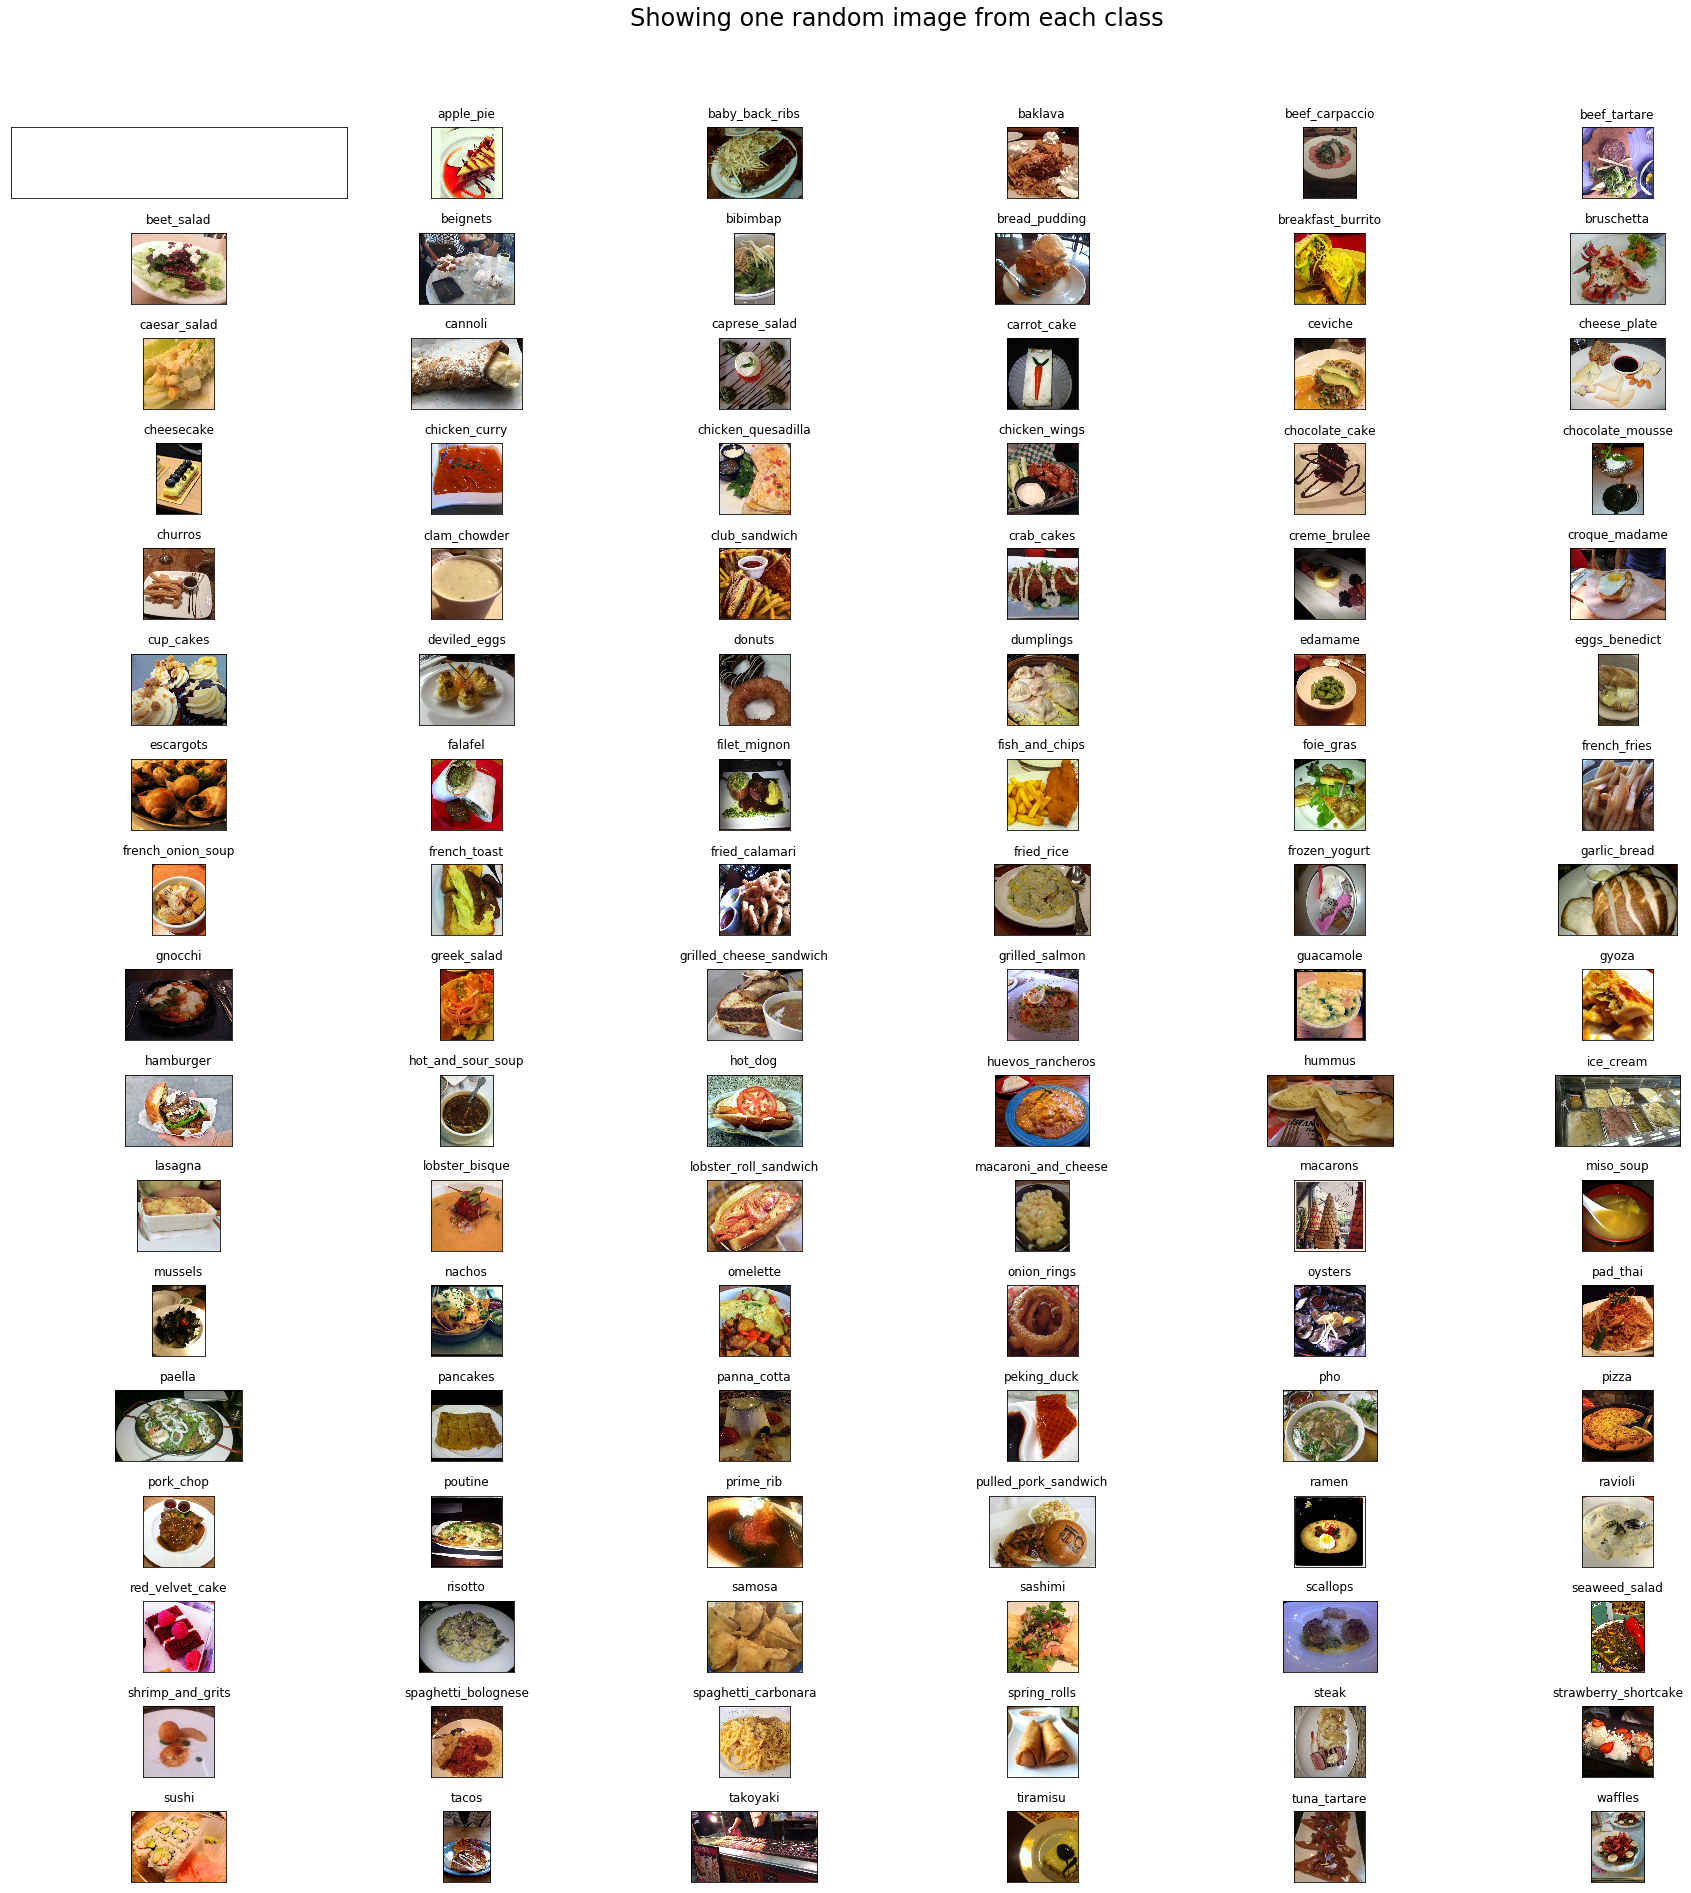

In [10]:
# Visualize the data, showing one image per class from 101 classes
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    if food_selected == '.DS_Store':
        continue
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()
# https://matplotlib.org/users/tight_layout_guide.html


### **Split the image data into train and test using train.txt and test.txt**

In [11]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [12]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
%cd /
print("Creating train data...")
prepare_data('/kaggle/input/food-101/food-101/meta/train.txt', '/kaggle/input/food-101/food-101/images', 'train')

/
Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying 

In [13]:
# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
print("Creating test data...")
prepare_data('/kaggle/input/food-101/food-101/meta/test.txt', '/kaggle/input/food-101/food-101/images', 'test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [14]:
# Check how many files are in the train folder
print("Total number of samples in train folder")
!find train -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
75750


In [15]:
# Check how many files are in the test folder
print("Total number of samples in test folder")
!find test -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
25250


In [16]:
os.chdir('/')

### **Create a subset of data with few classes(3) - train_mini and test_mini for experimenting**

In [17]:
# List of all 101 types of foods(sorted alphabetically)
del foods_sorted[0] # remove .DS_Store from the list

In [18]:
foods_sorted

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [19]:
# Helper method to create train_mini and test_mini data samples
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))
      

In [20]:
# picking 3 food items and generating separate data folders for the same
food_list = ['apple_pie','pizza','omelette']
src_train = 'train'
dest_train = '/kaggle/working/train_mini'
src_test = 'test'
dest_test = '/kaggle/working/test_mini'

In [21]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [22]:
print("Total number of samples in train folder")

!find /kaggle/working/train_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
2250


In [23]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [24]:
print("Total number of samples in test folder")
!find /kaggle/working/test_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
750


### **Fine tune ResNet50 Pretrained model using Food 101 dataset**

In [25]:
from tensorflow.keras.applications.resnet50 import ResNet50

K.clear_session()
n_classes = 3
img_width, img_height = 224, 224
train_data_dir = '/kaggle/working/train_mini'
validation_data_dir = '/kaggle/working/test_mini'
nb_train_samples = 2250 #75750
nb_validation_samples = 750 #25250
batch_size = 16

In [26]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.


In [27]:
resnet50 = ResNet50(weights='imagenet', include_top=False)
x = resnet50.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(3,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 0s 0us/step


In [28]:
model = Model(inputs=resnet50.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='/kaggle/working/best_model_3class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('/kaggle/working/history_3class.log')

history = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=30,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('/kaggle/working/model_trained_3class.hdf5')

Epoch 1/30
139/140 [============================>.] - ETA: 0s - loss: 1.0502 - acc: 0.5011
Epoch 00001: val_loss improved from inf to 1.25440, saving model to /kaggle/working/best_model_3class.hdf5
140/140 [==============================] - 68s 488ms/step - loss: 1.0498 - acc: 0.5015 - val_loss: 1.2544 - val_acc: 0.2704
Epoch 2/30
139/140 [============================>.] - ETA: 0s - loss: 0.7661 - acc: 0.6988
Epoch 00002: val_loss did not improve from 1.25440
140/140 [==============================] - 48s 345ms/step - loss: 0.7653 - acc: 0.6992 - val_loss: 1.3072 - val_acc: 0.3329
Epoch 3/30
139/140 [============================>.] - ETA: 0s - loss: 0.6204 - acc: 0.7697
Epoch 00003: val_loss did not improve from 1.25440
140/140 [==============================] - 47s 338ms/step - loss: 0.6197 - acc: 0.7700 - val_loss: 1.4685 - val_acc: 0.3573
Epoch 4/30
139/140 [============================>.] - ETA: 0s - loss: 0.5301 - acc: 0.8125
Epoch 00004: val_loss did not improve from 1.25440
140/

In [29]:
class_map_3 = train_generator.class_indices
class_map_3

{'apple_pie': 0, 'omelette': 1, 'pizza': 2}

### **Visualize the accuracy and loss plots**

In [30]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

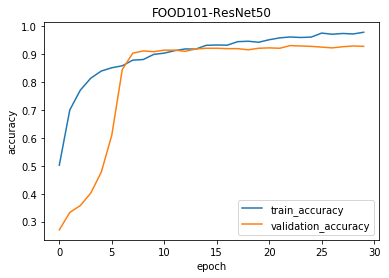

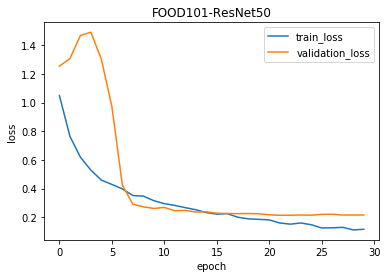

In [31]:
plot_accuracy(history,'FOOD101-ResNet50')
plot_loss(history,'FOOD101-ResNet50')

### **Predicting classes for new images from internet using the best trained model**

In [32]:
%%time
# Loading the best saved model to make predictions
K.clear_session()
model_best = load_model('/kaggle/working/best_model_3class.hdf5',compile = False)

CPU times: user 5.85 s, sys: 196 ms, total: 6.04 s
Wall time: 6 s


In [33]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(224, 224))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img /= 255.                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

In [34]:
!pip install openai

    100% |████████████████████████████████| 163kB 6.6MB/s ta 0:00:01
  Could not find a version that satisfies the requirement pandas>=1.2.3 (from openai) (from versions: 0.1, 0.2, 0.3.0, 0.4.0, 0.4.1, 0.4.2, 0.4.3, 0.5.0, 0.6.0, 0.6.1, 0.7.0, 0.7.1, 0.7.2, 0.7.3, 0.8.0, 0.8.1, 0.9.0, 0.9.1, 0.10.0, 0.10.1, 0.11.0, 0.12.0, 0.13.0, 0.13.1, 0.14.0, 0.14.1, 0.15.0, 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.16.2, 0.17.0, 0.17.1, 0.18.0, 0.18.1, 0.19.0, 0.19.1, 0.19.2, 0.20.0, 0.20.1, 0.20.2, 0.20.3, 0.21.0, 0.21.1, 0.22.0, 0.23.0, 0.23.1, 0.23.2, 0.23.3, 0.23.4, 0.24.0, 0.24.1, 0.24.2, 0.25.0, 0.25.1, 0.25.2, 0.25.3, 1.0.0, 1.0.1, 1.0.2, 1.0.3, 1.0.4, 1.0.5, 1.1.0, 1.1.1, 1.1.2, 1.1.3, 1.1.4, 1.1.5)
No matching distribution found for pandas>=1.2.3 (from openai)
You are using pip version 18.1, however version 21.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [35]:
# Downloading images from internet using the URLs
!wget -O samosa.jpg http://veggiefoodrecipes.com/wp-content/uploads/2016/05/lentil-samosa-recipe-01.jpg
!wget -O applepie.jpg https://cdn.pixabay.com/photo/2015/12/01/08/13/apple-pie-1071747_640.jpg
!wget -O pizza.jpg https://img.freepik.com/free-photo/top-view-pepperoni-pizza-with-mushroom-sausages-bell-pepper-olive-corn-black-wooden_141793-2158.jpg?w=2000
!wget -O omelette.jpg https://cdn.pixabay.com/photo/2015/05/20/16/11/kitchen-775746_640.jpg

--2023-09-30 21:38:17--  http://veggiefoodrecipes.com/wp-content/uploads/2016/05/lentil-samosa-recipe-01.jpg
Resolving veggiefoodrecipes.com (veggiefoodrecipes.com)... 45.77.209.234
Connecting to veggiefoodrecipes.com (veggiefoodrecipes.com)|45.77.209.234|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75560 (74K) [image/jpeg]
Saving to: ‘samosa.jpg’

samosa.jpg          100%[===================>]  73.79K  --.-KB/s    in 0.1s    

2023-09-30 21:38:18 (602 KB/s) - ‘samosa.jpg’ saved [75560/75560]

--2023-09-30 21:38:19--  https://cdn.pixabay.com/photo/2015/12/01/08/13/apple-pie-1071747_640.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 172.64.147.160, 104.18.40.96, 2606:4700:4400::6812:2860, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|172.64.147.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81352 (79K) [binary/octet-stream]
Saving to: ‘applepie.jpg’

applepie.jpg        100%[===================>]  79.45K  --.-KB/s    i

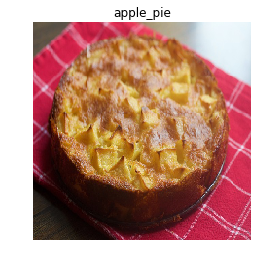

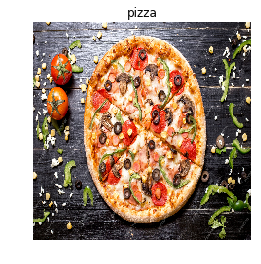

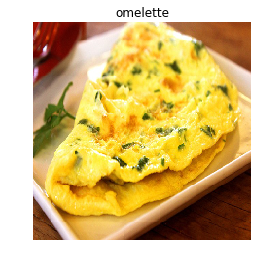

In [36]:
# Make a list of downloaded images and test the trained model
images = []
images.append('applepie.jpg')
images.append('pizza.jpg')
images.append('omelette.jpg')
predict_class(model_best, images, True)

### **Fine tune ResNet50 model with 11 classes of data**

In [37]:
# Helper function to select n random food classes
def pick_n_random_classes(n):
  food_list = []
  random_food_indices = random.sample(range(len(foods_sorted)),n) # We are picking n random food classes
  for i in random_food_indices:
    food_list.append(foods_sorted[i])
  food_list.sort()
  return food_list

In [38]:
# Lets try with more classes than just 3. Also, this time lets randomly pick the food classes
n = 11
food_list = pick_n_random_classes(n)
food_list = ['apple_pie', 'beef_carpaccio', 'bibimbap', 'cup_cakes', 'foie_gras', 'french_fries', 'garlic_bread', 'pizza', 'spring_rolls', 'spaghetti_carbonara', 'strawberry_shortcake']
print("These are the randomly picked food classes we will be training the model on...\n", food_list)

These are the randomly picked food classes we will be training the model on...
 ['apple_pie', 'beef_carpaccio', 'bibimbap', 'cup_cakes', 'foie_gras', 'french_fries', 'garlic_bread', 'pizza', 'spring_rolls', 'spaghetti_carbonara', 'strawberry_shortcake']


In [39]:
# Create the new data subset of n classes
print("Creating training data folder with new classes...")
dataset_mini(food_list, src_train, dest_train)

Creating training data folder with new classes...
Copying images into apple_pie
Copying images into beef_carpaccio
Copying images into bibimbap
Copying images into cup_cakes
Copying images into foie_gras
Copying images into french_fries
Copying images into garlic_bread
Copying images into pizza
Copying images into spring_rolls
Copying images into spaghetti_carbonara
Copying images into strawberry_shortcake


In [40]:
print("Total number of samples in train folder")
!find /kaggle/working/train_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
8250


In [41]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into apple_pie
Copying images into beef_carpaccio
Copying images into bibimbap
Copying images into cup_cakes
Copying images into foie_gras
Copying images into french_fries
Copying images into garlic_bread
Copying images into pizza
Copying images into spring_rolls
Copying images into spaghetti_carbonara
Copying images into strawberry_shortcake


In [42]:
# Let's use a pretrained Inceptionv3 model on subset of data with 11 food classes
K.clear_session()

n_classes = n
img_width, img_height = 224, 224
train_data_dir = '/kaggle/working/train_mini'
validation_data_dir = '/kaggle/working/test_mini'
nb_train_samples = 8250 #75750
nb_validation_samples = 2750 #25250
batch_size = 16

In [43]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 8250 images belonging to 11 classes.
Found 2750 images belonging to 11 classes.


In [44]:
resnet50 = ResNet50(weights='imagenet', include_top=False)
x = resnet50.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(n,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=resnet50.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='/kaggle/working/best_model_11class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('/kaggle/working/history_11class.log')

history_11class = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=30,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Epoch 1/30
514/515 [============================>.] - ETA: 0s - loss: 1.8951 - acc: 0.4094
Epoch 00001: val_loss improved from inf to 2.62005, saving model to /kaggle/working/best_model_11class.hdf5
515/515 [==============================] - 197s 382ms/step - loss: 1.8946 - acc: 0.4096 - val_loss: 2.6201 - val_acc: 0.1356
Epoch 2/30
514/515 [============================>.] - ETA: 0s - loss: 1.0694 - acc: 0.6956
Epoch 00002: val_loss improved from 2.62005 to 0.70216, saving model to /kaggle/working/best_model_11class.hdf5
515/515 [==============================] - 183s 355ms/step - loss: 1.0694 - acc: 0.6955 - val_loss: 0.7022 - val_acc: 0.8085
Epoch 3/30
514/515 [============================>.] - ETA: 0s - loss: 0.8620 - acc: 0.7587
Epoch 00003: val_loss improved from 0.70216 to 0.54524, saving model to /kaggle/working/best_model_11class.hdf5
515/515 [==============================] - 182s 353ms/step - loss: 0.8626 - acc: 0.7585 - val_loss: 0.5452 - val_acc: 0.8498
Epoch 4/30
514/515 [

In [45]:
class_map_11 = train_generator.class_indices
class_map_11

{'apple_pie': 0,
 'beef_carpaccio': 1,
 'bibimbap': 2,
 'cup_cakes': 3,
 'foie_gras': 4,
 'french_fries': 5,
 'garlic_bread': 6,
 'pizza': 7,
 'spaghetti_carbonara': 8,
 'spring_rolls': 9,
 'strawberry_shortcake': 10}

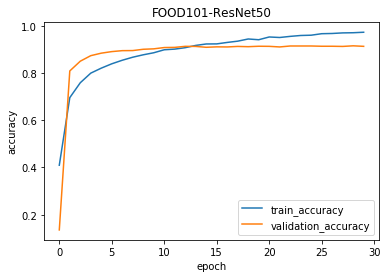

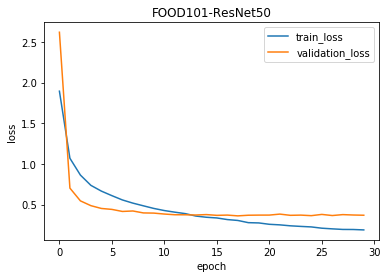

In [46]:
plot_accuracy(history_11class,'FOOD101-ResNet50')
plot_loss(history_11class,'FOOD101-ResNet50')